In [ ]:
# !pip install deepface
# !pip install opencv-python
# !pip install scikit-image

In [1]:
import cv2
import numpy as np
from skimage import io


In [9]:
alg = "haarcascade_frontalface_default.xml"
haar_cascade = cv2.CascadeClassifier(alg)
file_name = "data/955px-NASA_Astronaut_Group_18.jpg"

img = cv2.imread(file_name, 0)
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

faces = haar_cascade.detectMultiScale(grey_img, scaleFactor=1.15, minNeighbors=3, minSize=(60, 60))


In [10]:
faces.shape

(17, 4)

In [8]:
i = 0

for x,y,w,h in faces:
    cropped_image = img[y:y+h, x: x+w]
    target_file_name = 'stored_faces/' + str(i) + '.jpg'
    cv2.imwrite(target_file_name, cropped_image)
    i = i+1
    


Some reference  
YuNet
https://medium.com/pythons-gurus/what-is-the-best-face-detector-ab650d8c1225  
https://learnopencv.com/what-is-face-detection-the-ultimate-guide/  


In [ ]:
# !wget https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx -P ./model/



In [2]:
class FaceDetectorYunet():
    def __init__(self, model_path='./model/face_detection_yunet_2023mar.onnx', img_size=(300, 300), threshold=0.5):
        self.model_path = model_path
        self.img_size = img_size
        self.fd = cv2.FaceDetectorYN_create(str(model_path), "", img_size, score_threshold=threshold)


    def draw_faces(self, image, faces, draw_landmarks=False, show_confidence=False):
        for face in faces:
            color = (0, 0, 255)
            thickness = 2
            cv2.rectangle(image, (face['x1'], face['y1']), (face['x2'], face['y2']), color, thickness, cv2.LINE_AA)

            if draw_landmarks:
                landmarks = face['landmarks']
                for landmark in landmarks:
                    radius = 5
                    thickness = -1
                    cv2.circle(image, landmark, radius, color, thickness, cv2.LINE_AA)

            if show_confidence:
                confidence = face['confidence']
                confidence = "{:.2f}".format(confidence)
                position = (face['x1'], face['y1'] - 10)
                font = cv2.FONT_HERSHEY_SIMPLEX
                scale = 0.5
                thickness = 2
                cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)
        return image

    def scale_coords(self, image, prediction):
        ih, iw = image.shape[:2]
        rw, rh = self.img_size
        a = np.array([
                (prediction['x1'], prediction['y1']),
                (prediction['x1'] + prediction['x2'], prediction['y1'] + prediction['y2'])
                    ])
        b = np.array([iw/rw, ih/rh])
        c = a * b
        prediction['img_width'] = iw
        prediction['img_height'] = ih
        prediction['x1'] = int(c[0,0].round())
        prediction['x2'] = int(c[1,0].round())
        prediction['y1'] = int(c[0,1].round())
        prediction['y2'] = int(c[1,1].round())
        prediction['face_width'] = (c[1,0] - c[0,0])
        prediction['face_height'] = (c[1,1] - c[0,1])
        # prediction['face_width'] = prediction['x2'] - prediction['x1']
        # prediction['face_height'] = prediction['y2'] - prediction['y1']
        prediction['area'] = prediction['face_width'] * prediction['face_height']
        prediction['pct_of_frame'] = prediction['area']/(prediction['img_width'] * prediction['img_height'])
        return prediction

    def detect(self, image):
        if isinstance(image, str):
            image = cv2.imread(str(image))
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        img = cv2.resize(gray_img, self.img_size)
        self.fd.setInputSize(self.img_size)
        _, faces = self.fd.detect(img)
        if faces is None:
            return None
        else:
            predictions = self.parse_predictions(image, faces)
            return predictions

    def parse_predictions(self, image, faces):
        data = []
        for num, face in enumerate(list(faces)):
            x1, y1, x2, y2 = list(map(int, face[:4]))
            landmarks = list(map(int, face[4:len(face)-1]))
            landmarks = np.array_split(landmarks, len(landmarks) / 2)
            positions = ['left_eye', 'right_eye', 'nose', 'right_mouth', 'left_mouth']
            landmarks = {positions[num]: x.tolist() for num, x in enumerate(landmarks)}
            confidence = face[-1]
            datum = {'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'face_num': num,
            'landmarks': landmarks,
            'confidence': confidence,
            'model': 'yunet'}
        d = self.scale_coords(image, datum)
        data.append(d)
        return data


In [46]:
file_name = "data/636px-NASA_Astronaut_Group_18.jpg"
file_name = "data/img_2.jpg"

# img = cv2.imread(file_name, 0)
img = io.imread(file_name)
# # img = io.imread('https://github.com/astaileyyoung/CineFace/blob/main/research/notebooks/images/img_2.jpg?raw=true')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fd = FaceDetectorYunet()
faces = fd.detect(img)
if faces:
    fd.draw_faces(img, faces)
# show_image(img)

In [48]:
len(faces)

1

(-0.5, 639.5, 279.5, -0.5)

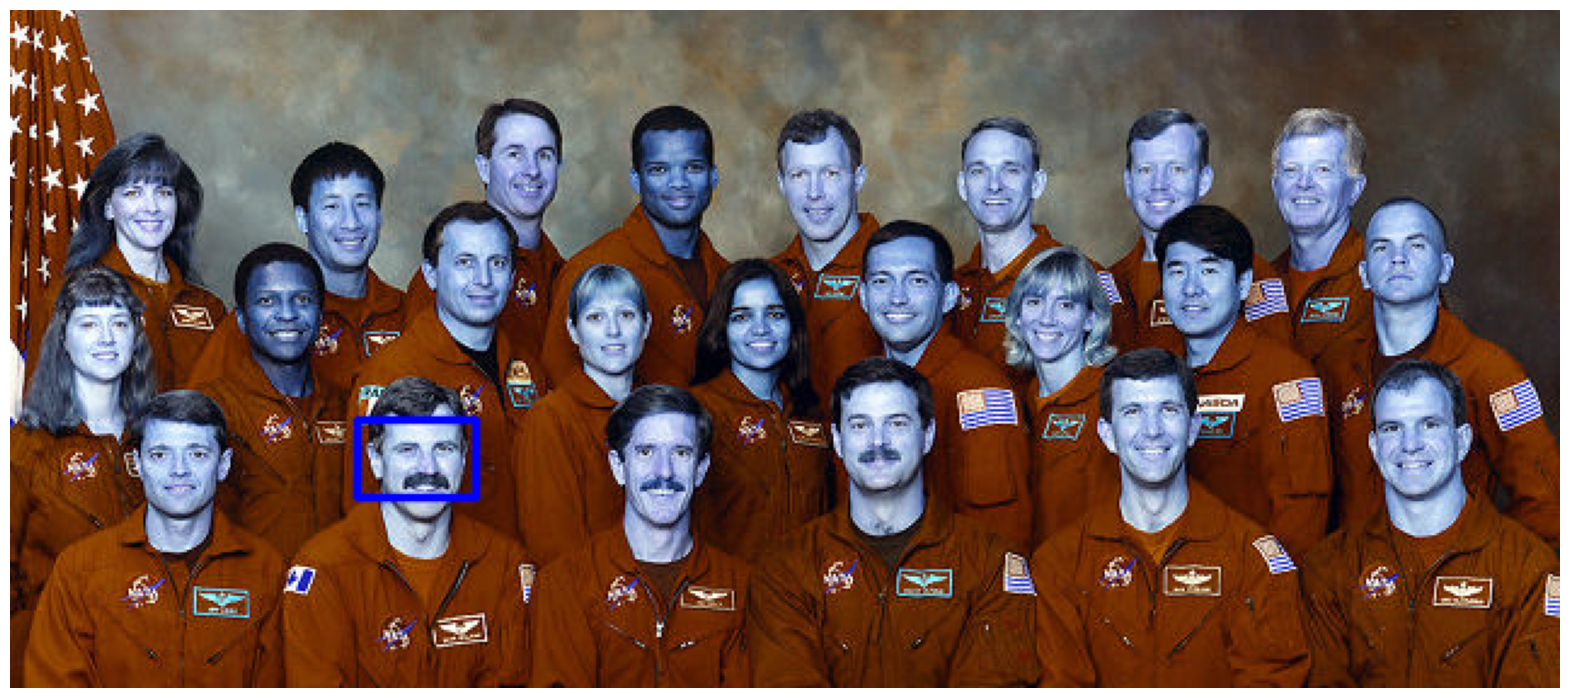

In [49]:
import matplotlib.pyplot as plt



plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')